#  Entity Explorer - Domain and URL
 <details>
     <summary>&nbsp;<u>Details...</u></summary>

 **Notebook Version:** 1.0<br>
 **Python Version:** Python 3.6 (including Python 3.6 - AzureML)<br>
 **Required Packages**: kqlmagic, msticpy, pandas, numpy, matplotlib, networkx, ipywidgets, ipython, dnspython, ipwhois, folium, maxminddb_geolite2<br>
 **Platforms Supported**:
 - Azure Notebooks Free Compute
 - Azure Notebooks DSVM
 - OS Independent

 **Data Sources Required**:
 - Log Analytics - Syslog, SecurityEvent, DnsEvents, CommonSecurityLog, AzureNetworkAnalytics_CL
 - (Optional) - VirusTotal, AlienVault OTX, IBM XForce, Open Page Rank, BrowShot (all require accounts and API keys)
 </details>

This Notebooks brings together a series of tools and techniques to enable threat hunting within the context of a domain name or URL that has been identified as of interest. It provides a series of techniques to assist in determining whether a domain or URL is malicious. Once this has been established it provides an overview of the scope of the domain or URL across an environment, along with indicators of areas for further investigation such as hosts of interest.  

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-Setup" data-toc-modified-id="Notebook-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook Setup</a></span><ul class="toc-item"><li><span><a href="#Get-WorkspaceId-and-Authenticate-to-Log-Analytics" data-toc-modified-id="Get-WorkspaceId-and-Authenticate-to-Log-Analytics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get WorkspaceId and Authenticate to Log Analytics</a></span><ul class="toc-item"><li><span><a href="#Authentication-and-Configuration-Problems" data-toc-modified-id="Authentication-and-Configuration-Problems-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Authentication and Configuration Problems</a></span></li></ul></li></ul></li><li><span><a href="#Select-the-domain-or-URL-you-wish-to-investigate" data-toc-modified-id="Select-the-domain-or-URL-you-wish-to-investigate-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Select the domain or URL you wish to investigate</a></span></li><li><span><a href="#Domain-Overview" data-toc-modified-id="Domain-Overview-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Domain Overview</a></span><ul class="toc-item"><li><span><a href="#Threat-Intelligence" data-toc-modified-id="Threat-Intelligence-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Threat Intelligence</a></span></li><li><span><a href="#Domain-analysis" data-toc-modified-id="Domain-analysis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Domain analysis</a></span></li><li><span><a href="#TLS-Cert-Details" data-toc-modified-id="TLS-Cert-Details-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>TLS Cert Details</a></span></li><li><span><a href="#Reverse-DNS-details" data-toc-modified-id="Reverse-DNS-details-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Reverse DNS details</a></span></li><li><span><a href="#Site-Screenshot" data-toc-modified-id="Site-Screenshot-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Site Screenshot</a></span></li><li><span><a href="#Domain-Summary" data-toc-modified-id="Domain-Summary-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Domain Summary</a></span></li></ul></li><li><span><a href="#Related-Alerts" data-toc-modified-id="Related-Alerts-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Related Alerts</a></span></li><li><span><a href="#Domain-or-URL-in-Logs" data-toc-modified-id="Domain-or-URL-in-Logs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Domain or URL in Logs</a></span><ul class="toc-item"><li><span><a href="#Host-Logs" data-toc-modified-id="Host-Logs-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Host Logs</a></span></li><li><span><a href="#Network-Device-Logs" data-toc-modified-id="Network-Device-Logs-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Network Device Logs</a></span></li><li><span><a href="#DNS-Logs" data-toc-modified-id="DNS-Logs-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>DNS Logs</a></span></li><li><span><a href="#Flow-Logs" data-toc-modified-id="Flow-Logs-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Flow Logs</a></span></li><li><span><a href="#All-Hosts-Observed-Communicating-with-the-Domain-or-URL" data-toc-modified-id="All-Hosts-Observed-Communicating-with-the-Domain-or-URL-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>All Hosts Observed Communicating with the Domain or URL</a></span></li></ul></li><li><span><a href="#Summary-of-Findings" data-toc-modified-id="Summary-of-Findings-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summary of Findings</a></span></li><li><span><a href="#Setup-Cell" data-toc-modified-id="Setup-Cell-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Setup Cell</a></span></li></ul></div>

# Hunting Hypothesis: 
Our broad initial hunting hypothesis is that a particular Linux host in our environment has been compromised, we will need to hunt from a range of different positions to validate or disprove this hypothesis.

Before you start hunting please run the setup cells at the bottom of this Notebook. 

## Notebook Setup
If this is your first time running this Notebook please run the cells in in the Setup section before proceeding to ensure you have the required packages installed correctly. Similarly, if you see any import failures (ImportError) in the notebook, please make sure that you have read and run the cells Setup section first. This section is at the end of the notebook.

In [1]:
print('Importing python packages....')
import sys
import warnings
MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)
    
import re
import json
import numpy as np
import time
import requests
import seaborn as sns
sns.set()
import ipywidgets as widgets
import pandas as pd
print('Importing msticpy packages...')
from msticpy.sectools import *
from msticpy.nbtools import *
from msticpy.nbtools.utility import md
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
WIDGET_DEFAULTS = {'layout': widgets.Layout(width="900px"),
                   'style': {'description_width': 'initial'}}
from pyvis.network import Network
from IPython.display import Image, Markdown, HTML
from msticpy.data.data_providers import QueryProvider
from msticpy.sectools import tilookup
from msticpy.nbtools.utility import md, md_warn
from msticpy.sectools import domain_utils
from msticpy.nbtools import observationlist

from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)
pd.options.mode.chained_assignment = None
%env KQLMAGIC_LOAD_MODE=silent
print('Imports complete')

Importing python packages....
Importing msticpy packages...


Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank
env: KQLMAGIC_LOAD_MODE=silent
Imports complete


### Get WorkspaceId and Authenticate to Log Analytics
<details>
    <summary> <u>Details...</u></summary>
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

Note: you may occasionally see a JavaScript error displayed at the end of the authentication - you can safely ignore this.<br>
On successful authentication you should see a ```popup schema``` button.
To find your Workspace Id go to [Log Analytics](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.
</details>

In [2]:
#See if we have an Azure Sentinel Workspace defined in our config file, if not let the user specify Workspace and Tenant IDs
from msticpy.nbtools.wsconfig import WorkspaceConfig
ws_config = WorkspaceConfig()
try:
    ws_id = ws_config['workspace_id']
    ten_id = ws_config['tenant_id']
    config = True
    md("Workspace details collected from config file")
except KeyError:
    md(('Please go to your Log Analytics workspace, copy the workspace ID'
                 ' and/or tenant Id and paste here to enable connection to the workspace and querying of it..<br> '))
    ws_id_wgt = nbwidgets.GetEnvironmentKey(env_var='WORKSPACE_ID',
                                        prompt='Please enter your Log Analytics Workspace Id:', auto_display=True)
    ten_id_wgt = nbwidgets.GetEnvironmentKey(env_var='TENANT_ID',
                                         prompt='Please enter your Log Analytics Tenant Id:', auto_display=True)
    config = False


<p style=''>Workspace details collected from config file</p>

In [3]:
if config is False:
    ws_id = ws_id_wgt.value
    ten_id = ten_id_wgt.value
# Establish a query provider for Azure Sentinel and connect to it
qry_prov = QueryProvider('LogAnalytics')
la_connection_string = f'loganalytics://code().tenant("{ten_id}").workspace("{ws_id}")'
qry_prov.connect(connection_str=f'{la_connection_string}')
tilookup = TILookup()

Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Authentication and Configuration Problems

<br>
<details>
    <summary>Click for details about configuring your authentication parameters</summary>
    
The notebook is expecting your Azure Sentinel Tenant ID and Workspace ID to be configured in one of the following places:
- `config.json` in the current folder
- `msticpyconfig.yaml` in the current folder or location specified by `MSTICPYCONFIG` environment variable.
    
For help with setting up your `config.json` file (if this hasn't been done automatically) see the [`ConfiguringNotebookEnvironment`](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/ConfiguringNotebookEnvironment.ipynb) notebook in the root folder of your Azure-Sentinel-Notebooks project. This shows you how to obtain your Workspace and Subscription IDs from the Azure Sentinel Portal. You can use the SubscriptionID to find your Tenant ID). To view the current `config.json` run the following in a code cell.

```%pfile config.json```

For help with setting up your `msticpyconfig.yaml` see the [Setup](#Setup) section at the end of this notebook and the [ConfigureNotebookEnvironment notebook](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/ConfiguringNotebookEnvironment.ipynb)
</details>

## Select the domain or URL you wish to investigate
Enter the domain or URL you wish to investigate.

In [4]:
domain_url = widgets.Text(description='Please enter your the domain or URL to investigate:',
                          **WIDGET_DEFAULTS)
display(domain_url)
#                                          auto_display=True)

Text(value='', description='Please enter your the domain or URL to investigate:', layout=Layout(width='900px')…

In [5]:
import tldextract
graph_items = []
dom_val = domain_utils.DomainValidator()
summary = observationlist.Observations()
dom_record = None
url=domain_url.value.strip().lower()
_, domain, tld = tldextract.extract(domain_url.value)
domain = domain.lower() + "." + tld.lower()
if dom_val.validate_tld(domain) is not True:
    md(f"{domain} is not a valid domain name", "bold")

if url != domain:
    md(f"<strong>Domain</strong> : {domain}")
    md(f"<strong>URL</strong> : {url}")
    graph_items.append((domain,url))
else:
    md(f"<strong>Domain</strong> : {domain}")
    url = None

<p style=''><strong>Domain</strong> : raiseyourdongers.pw</p>

<p style=''><strong>URL</strong> : https://ohyaya.raiseyourdongers.pw/</p>

If you are certain the above indicators are malicious and wish to jump straight to investigating thier scope of impact in the environment jump to <a>Related Alerts</a>.

## Domain Overview

### Threat Intelligence
As a first step we want to establish if this domain or URL is known to to be malicious by our Threat Intelligence providers.

#### msticpyconfig.yaml configuration file
You can configure primary and secondary TI providers and any required parameters in the msticpyconfig.yaml file. This is read from the current directory or you can set an environment variable (MSTICPYCONFIG) pointing to its location. To configure this file see the ConfigureNotebookEnvironment notebook.

In [6]:
domain_ti = tilookup.result_to_df(tilookup.lookup_ioc(observable=domain, ioc_type='dns'))
if url is not None:
    url_ti = tilookup.result_to_df(tilookup.lookup_ioc(observable=url, ioc_type='url'))
    md(f"Threat Intelligence Results for {url}", "bold")
    display(url_ti.T)
    summary.add_observation(caption="URL TI", description=f"Summary of TI for {url}", data=url_ti)
    graph_items += [((url,provider)) for provider in url_ti.index if url_ti.loc[provider]['Severity'] > 0] 
md(f"Threat Intelligence Results for {domain}", "bold")
display(domain_ti.T)
summary.add_observation(caption="Domain TI", description=f"Summary of TI for {domain}", data=domain_ti)
graph_items += [((domain,provider)) for provider in domain_ti.index if domain_ti.loc[provider]['Severity'] > 0]

<p style='font-weight: bold'>Threat Intelligence Results for https://ohyaya.raiseyourdongers.pw/</p>

,OTX,VirusTotal,XForce
Ioc,https://ohyaya.raiseyourdongers.pw/,https://ohyaya.raiseyourdongers.pw/,https://ohyaya.raiseyourdongers.pw/
IocType,url,url,url
QuerySubtype,None,None,None
Provider,OTX,VirusTotal,XForce
Result,True,True,True
Severity,0,2,0
Details,"{'pulse_count': 0, 'sections_available': ['general', 'url_list', 'http_scans']}","{'verbose_msg': 'Scan finished, scan information embedded in this object', 'response_code': 1, '...","{'score': 0, 'cats': None, 'categoryDescriptions': None, 'reason': None, 'reasonDescription': 0,..."
RawResult,"{'indicator': 'https://ohyaya.raiseyourdongers.pw', 'alexa': 'http://www.alexa.com/siteinfo/rais...","{'scan_id': '13e056c9a3260e4d793da66079c87b5c6d14b31ec5ecf15793fdc21c2efb8397-1572358897', 'reso...","{'result': {'url': 'raiseyourdongers.pw', 'cats': {'Malware': True, 'Botnet Command and Control ..."
Reference,https://otx.alienvault.com/api/v1/indicators/url/https://ohyaya.raiseyourdongers.pw//general,https://www.virustotal.com/vtapi/v2/url/report,https://api.xforce.ibmcloud.com/url/https://ohyaya.raiseyourdongers.pw/
Status,0,0,0


<p style='font-weight: bold'>Threat Intelligence Results for raiseyourdongers.pw</p>

,OTX,VirusTotal,XForce
Ioc,raiseyourdongers.pw,raiseyourdongers.pw,raiseyourdongers.pw
IocType,dns,dns,dns
QuerySubtype,None,None,None
Provider,OTX,VirusTotal,XForce
Result,True,True,True
Severity,2,2,0
Details,"{'pulse_count': 2, 'names': ['Moobot and Fbot', 'Moobot and Fbot'], 'tags': [['mirai', 'iot'], [...","{'verbose_msg': 'Domain found in dataset', 'response_code': 1, 'detected_urls': ['https://raisey...","{'score': 0, 'cats': None, 'categoryDescriptions': None, 'reason': None, 'reasonDescription': 0,..."
RawResult,"{'indicator': 'raiseyourdongers.pw', 'alexa': 'http://www.alexa.com/siteinfo/raiseyourdongers.pw...","{'undetected_referrer_samples': [], 'dns_records_date': 1572533321, 'detected_downloaded_samples...","{'result': {'url': 'raiseyourdongers.pw', 'cats': {'Malware': True, 'Botnet Command and Control ..."
Reference,https://otx.alienvault.com/api/v1/indicators/domain/raiseyourdongers.pw/general,https://www.virustotal.com/vtapi/v2/domain/report,https://api.xforce.ibmcloud.com/url/raiseyourdongers.pw
Status,0,0,0


### Domain analysis
To build up a fuller picture of the domain we can use whois, and other data sources to gather pertinent data. Indicators such as registration data, domain entropy, and registration details can provide indicators that a domain is not legitimate in nature.

This cell uses the Open Page Rank API (https://www.domcop.com/openpagerank/) - in order to use this you need to add your API key to your `msticpyconfig.yaml` configuration file (as you did for TI providers). Please see the `ConfigureNotebookEnvironment` notebook for more details on this.

In [7]:
from whois import whois
from collections import Counter
def Entropy(data):
    s, lens = Counter(data), np.float(len(data))
    return -sum(count/lens * np.log2(count/lens) for count in s.values())
#Get a whois record for our domain
wis = whois(domain)

if wis.domain_name is not None:
    # Create domain record from whois data
    dom_record = pd.DataFrame({"Domain":[domain],
                                   "Name":[wis['name']],
                                   "Org":[wis['org']],
                                   "DNSSec":[wis['dnssec']],
                                   "City":[wis['city']],
                                   "State":[wis['state']],
                                   "Country":[wis['country']],
                                   "Registrar": [wis['registrar']],
                                   "Status": [wis['status']],
                                   "Created":[wis['creation_date']],
                                   "Expiration" : [wis['expiration_date']],
                                   "Last Updated" : [wis['updated_date']],
                                   "Name Servers": [wis['name_servers']]})
    ns_domains = []
    
    # Remove duplicate Name Server records
    for server in wis['name_servers']:
        ns_sub_d, ns_domain, ns_tld = tldextract.extract(server)
        ns_dom = ns_domain.lower() + "." + ns_tld.lower()
        if domain not in ns_domains:
                   ns_domains.append(ns_dom)                                            
   
    # Identity domains populatirty with Open Page Rank
    page_rank = tilookup.result_to_df(tilookup.lookup_ioc(observable=domain, providers=["OPR"]))
    page_rank_score = page_rank['RawResult'][0]['response'][0]['page_rank_integer']
    dom_record["Page Rank"] = [page_rank_score]
   
    # Get a list of subdomains for the domain
    url_ti = tilookup.result_to_df(tilookup.lookup_ioc(observable=domain, providers=["VirusTotal"]))
    sub_doms = url_ti['RawResult'][0]['subdomains']
    graph_items.append((domain, "Sub Domains"))
    graph_items += [(sub,"Sub Domains") for sub in sub_doms]
    dom_record['Sub Domains'] = [sub_doms]
    
    # Work out domain entropy to identity possible DGA
    dom_ent = Entropy(domain)
    dom_record['Domains Entropy'] = [dom_ent]
    
    # Add elements to graph for later plotting
    if isinstance(dom_record['Created'],list):                                                        
        graph_items.append((domain,dom_record['Created'][0][0]))
    else:
        graph_items.append((domain,dom_record['Created'][0]))
    graph_items.append((domain, "Name Servers"))
    graph_items += [(("Name Servers", ns)) for ns in dom_record['Name Servers'][0]]
    graph_items += [(domain,dom_record['Registrar'][0]), (domain,dom_record['Country'][0]),(domain,f"Page Rank : {dom_record['Page Rank'][0]}")]
    
    #Highlight domains with low PageRank score or if thier entropy is more than 2 standard deviations from the average for the top 1 million domains
    def color_cells(val):
        if isinstance(val, int):
            color = 'yellow' if val < 3 else 'white'
        elif isinstance(val, float):
            color = 'yellow' if val > 4.30891 or val < 2.72120  else 'white'
        else:
            color = 'white'
        return 'background-color: %s' % color
    
    # Display whois details and highlight interesting values
    display(dom_record.T.style.applymap(color_cells, subset=pd.IndexSlice[['Page Rank', 'Domains Entropy'],0]))
    summary.add_observation(caption="Domain Summary", description=f"Summary of public domain records for {domain}", data=dom_record)
    md("If Page Rank or Domain Entropy are highlighted this indicates that their values are outside the expected values of a legitimate website")
    md(f"The average entropy for the 1M most popular domains is 3.2675")

else:
    # If there is no whois data see what we can use from TI
    url_ti = tilookup.result_to_df(tilookup.lookup_ioc(observable=domain, providers=["VirusTotal"]))
    md(f"No current whois record exists for {domain} below are historical records")
    print(url_ti['RawResult'][0]['whois'])

,0
Domain,raiseyourdongers.pw
Name,None
Org,None
DNSSec,unsigned
City,None
State,None
Country,None
Registrar,TLD Registrar Solutions Ltd
Status,clientTransferProhibited https://icann.org/epp#clientTransferProhibited
Created,2019-06-30 03:39:08


<p style=''>If Page Rank or Domain Entropy are highlighted this indicates that their values are outside the expected values of a legitimate website</p>

<p style=''>The average entropy for the 1M most popular domains is 3.2675</p>

### TLS Cert Details
Does the domain have an associated tls certificate and if so is that certificate blacklisted by abuse.ch?
Details such as the certificate's subject and issuer can also provide indicators as to the domains nature.

In [8]:
if url is not None:
    scope = url
else:
    scope = domain

# See if TLS cert is in abuse.ch blacklist and get cert details
result, x509 = dom_val.ssl_blacklisted(scope)

if x509 is not None:
    cert_df = pd.DataFrame({"SN" :[x509.serial_number],
                            "Subject":[[(i.value) for i in x509.subject]],
                            "Issuer": [[(i.value) for i in x509.issuer]],
                            "Expired": [x509.not_valid_after],
                            "In SSLBL?": result})

    display(cert_df.T)
    summary.add_observation(caption="TLS Summary", description=f"Summary of TLS certificate for {domain}", data=cert_df)
    md("If 'In SSLBL?' is True this shows that the SSL certificate figerprint appeared in the abuse.ch blacklist")
    graph_items.append((domain,result))

else:
    md("No Blacklisted TLS certificate was found.")

<p style=''>No Blacklisted TLS certificate was found.</p>

### Reverse DNS details
What IP address is assocatiated with this domain, what do we know about that IP?
What other domains have been associated with this IP, and is it a known ToR exit node?

In order to use this ToR lookup functionality of MSTICpy you need to configure it as a provider in your `msticpyconfig.yaml` configuration file. No API key is required to use this functionality. Please see the `ConfigureNotebookEnvironment` notebook for more details on this.

In [13]:
import dns.resolver
from dns.resolver import NXDOMAIN
from ipwhois import IPWhois
primary_providers = [prov[0] for prov in tilookup._providers.items()]

if "VirusTotal" in tilookup.loaded_providers and "VirusTotal" not in primary_providers:
    primary_providers.append("VirusTotal")

if dom_val.is_resolvable(domain) is True:
    try:
        answer = dns.resolver.query(domain, 'A')
    except NXDOMAIN:
        raise ValueError("Could not resolve IP addresses from domain.")
    x = answer[0].to_text()
    whois = IPWhois(x)
    ipwis = whois.lookup_whois()
    ip_rec = pd.DataFrame({"IP Address": [x],
                           "ASN" : [ipwis['asn']],
                         "ASN Owner": [ipwis['asn_description']],
                          "Country" : [ipwis['asn_country_code']],
                          "Date": [ipwis['asn_date']]})
    ip_addresses = ip_rec['IP Address'].to_list()
    graph_items += [
        (ip_rec["IP Address"][0],domain),
        (ip_rec["IP Address"][0],ip_rec["ASN"][0]),
        (ip_rec["ASN Owner"][0],ip_rec["ASN"][0]),
        (ip_rec["Country"][0],ip_rec["ASN"][0])
    ]
    
    tor = None
    if "Tor" in tilookup.loaded_providers:
        tor = tilookup.result_to_df(tilookup.lookup_ioc(observable=ip_rec['IP Address'][0], providers=["Tor"]))
    if tor is None or tor['Details'][0] == "Not found.":
        ip_rec['Tor Node?'] = "No"
    else:
        ip_rec['Tor Node?'] = "Yes"
        graph_items.append((ip_rec["IP Address"][0],"Tor Node"))
    ip_ti = tilookup.result_to_df(tilookup.lookup_ioc(observable=ip_rec['IP Address'][0], providers=primary_providers))
    last_10 = []
    if "VirusTotal" in tilookup.loaded_providers:
        last_10 = ip_ti.T['VirusTotal']['RawResult']["resolutions"][0:10]
    prev_domains = []
    for record in last_10:
        prev_domains.append(record['hostname'])
        graph_items.append((record['hostname'],ip_rec["IP Address"][0]))   
    ip_rec["Last 10 resolutions"] = [prev_domains]
    display(ip_rec.T)
    summary.add_observation(caption="IP Summary", description=f"Summary of IP assocaiated with {domain}", data=ip_rec)
else:
    ip_ti = tilookup.result_to_df(tilookup.lookup_ioc(observable=answer[0].to_text()))
    print(ip_ti.T['VirusTotal']['RawResult'])

,0
IP Address,5.206.227.65
ASN,49349
ASN Owner,"DOTSI, PT"
Country,PT
Date,2012-09-05
Tor Node?,No
Last 10 resolutions,"[ohyaya.raiseyourdongers.pw, raiseyourdongers.pw]"


### Site Screenshot
Using https://browshot.com/ return a screenshot of the domain or url being investigated. This can help us identify if the site is a phishing portal.

As with other external providers you need an API key to use the BrowShot service, and have the provider configured in your `msticpyconfig.yaml` file. Please see the `ConfigureNotebookEnvironment` notebook for more details on this.

Getting screenshot


IntProgress(value=0, max=40)

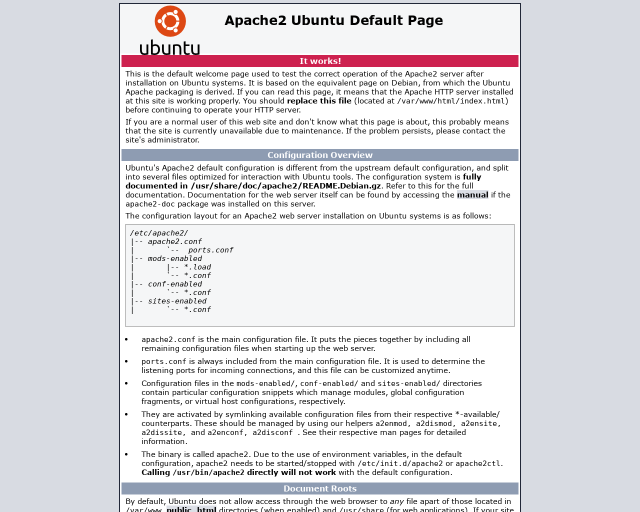

In [25]:
if url is not None:
    image_data = domain_utils.screenshot(url)
else:
    image_data = domain_utils.screenshot(domain)
    
with open('screenshot.png', 'wb') as f:
        f.write(image_data.content)

display(Image(filename='screenshot.png'))

### Domain Summary
In order to effectively evaluate the data collected above we will graph the elements to help highlight connections.

In [26]:
# Create graph from items saved to graph_items
import networkx as nx
import matplotlib.pyplot as plt
G=nx.Graph()
for item in graph_items:
    G.add_edge(item[0],str(item[1]))

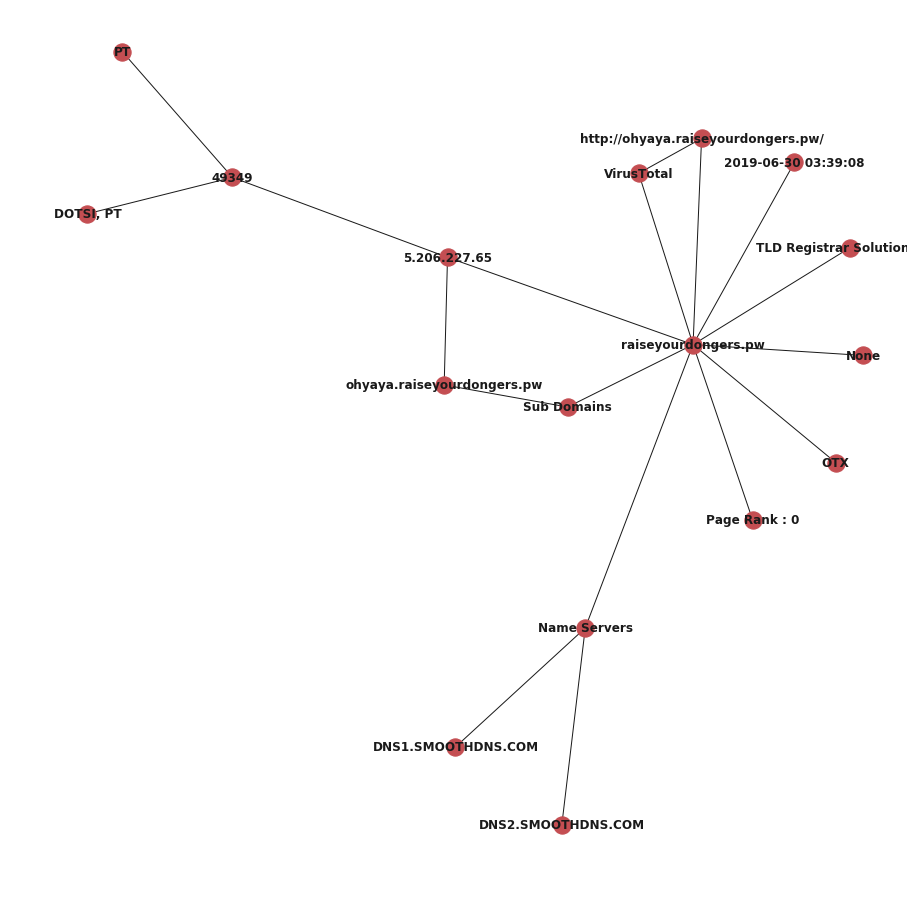

In [28]:
from IPython.display import HTML
# Plot Graph with pyvis
net=Network(height=900, width=900, notebook=True)
net.barnes_hut()
net.from_nx(G)
net.set_options("""
var options = {"nodes": {"color": {"highlight": {"border": "rgba(233,77,49,1)"},"hover": {"border": "rgba(233,77,49,1)"}},
    "scaling": {"min": 1},"size": 7},
    "edges": {"color": {"inherit": true}, "smooth": false},
    "interaction": {"hover": true,"multiselect": true},
    "manipulation": {"enabled": true},
    "physics": {"enabled": false,"barnesHut": {"gravitationalConstant": -80000,"springLength": 250,"springConstant": 0.001},"minVelocity": 0.75}
}""")
net.show("graph.html")
# If the intereactive graph does not display correcrtly uncomment the three lines below to access display a non-interactive version
#import matplotlib.pyplot as plt
#plt.figure(3,figsize=(12,12))
#nx.draw(G, with_labels=True, font_weight='bold')

# Domain/URL in the Environment
Once we have determined the nature of the domain or URL under investigation we want to see what the scope of impact is in our environment but identifying any presence of the domain or URL in our datasets.
If the domain has a high page rank score it is likely that it will be highly prevalent in a large environment, therefore you may wish to consider whether or not to run these cells for such a domain due to the data volumes involved.

In [35]:
if dom_record is None or int(dom_record["Page Rank"]) < 6:
    warning = None
else:
    md_warn(f"{domain} has a high Page Rank score, it is likely to be highly prevalent in the environment.")
    md("Please confirm below that you wish to proceed, note that some queries are likely to be slow due to large amounts of data", "bold")
    warning = widgets.Checkbox(
        value=False,
        description='Are you sure?',
        disabled=False
    )
    display(warning)

In [32]:
# Establish if we want to investigate just the URL or domain and URL
if warning is not None and warning.value == False:
    md_warn("Please check the box above to confirm you wish to proceed")
else:
    if url is not None:
        md("Do you wish to search on the URL alone or URL and Domain? For mallicious URLs on known good domains you may wish to only search on the URL to get more granular results.")
        scope_selection = widgets.RadioButtons(
            options=['URL Only', 'URL and Domain'],
            disabled=False
        )
        display(scope_selection)
    else:
        scope_selection = None
        md(f"Searching data for {domain}")
        
host_list = []

<p style=''>Do you wish to search on the URL alone or URL and Domain? For mallicious URLs on known good domains you may wish to only search on the URL to get more granular results.</p>

RadioButtons(options=('URL Only', 'URL and Domain'), value='URL Only')

In [33]:
# Set a time scope for our investigation
if scope_selection is not None:
    if scope_selection.value == "URL Only":
        scope = url
    else:
        scope = f"{domain}|{url}"
else:
    scope = domain

query_times = nbwidgets.QueryTime(units='day',
                                      max_before=20, max_after=1, before=3)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

## Related Alerts

In [34]:
#Get any alerts associated with the domain or URL
alerts = qry_prov.SecurityAlert.list_alerts(
    query_times)
if isinstance(alerts, pd.DataFrame) and not alerts.empty:
    related_alerts = alerts[alerts["Entities"].str.contains(scope)]
else:
    alerts = None
    display(HTML("No alerts found"))


if isinstance(related_alerts, pd.DataFrame) and not related_alerts.empty:
    related_alerts_items = (related_alerts[['AlertName', 'TimeGenerated']]
                        .groupby('AlertName').TimeGenerated.agg('count').to_dict())

    def print_related_alerts(alertDict, entityType, entityName):
        if len(alertDict) > 0:
            display(Markdown(
                f"### Found {len(alertDict)} different alert types related to this {entityType} (\'{entityName}\')"))
            for (k, v) in alertDict.items():
                display(Markdown(f"- {k}, Count of alerts: {v}"))
        else:
            display(
                Markdown(f"No alerts for {entityType} entity \'{entityName}\'"))


# Display alerts on timeline to aid in visual grouping
    print_related_alerts(related_alerts_items, 'domain', domain)
    nbdisplay.display_timeline(
        data=related_alerts, source_columns=["AlertName"], title="Host alerts over time", height=300, color="red")
    score = len(related_alerts.index)/2
    summary.add_observation(caption="Alerts", description=f"Alerts linked to {scope}", data=related_alerts, score=score)
else:
    md("No related alerts found.")

<IPython.core.display.Javascript object>

<p style=''>No related alerts found.</p>

In [36]:
rel_alert_select = None

def show_full_alert(selected_alert):
    global security_alert, alert_ip_entities
    security_alert = SecurityAlert(
        rel_alert_select.selected_alert)
    nbdisplay.display_alert(security_alert, show_entities=True)

# Show selected alert when selected
if isinstance(related_alerts, pd.DataFrame) and not related_alerts.empty:
    display(Markdown('### Click on alert to view details.'))
    rel_alert_select = nbwidgets.AlertSelector(alerts=related_alerts,
                                               action=show_full_alert)
    rel_alert_select.display()
else:
    md('No related alerts found.')

<p style=''>No related alerts found.</p>

## Domain or URL in Logs

### Host Logs
Hosts that have communicated with the domain or URL under investigation may have indicators of this activity in thier logs, especially if the domain or URL was referenced in a command line argument. The context that the domain or URL is observed in may provide some indication of what the activity was.

In [37]:
host_log_query = f"""
 Syslog 
 | where TimeGenerated >= datetime({query_times.start}) 
 | where TimeGenerated <= datetime({query_times.end})
 | where SyslogMessage matches regex "{scope}"
 | union isfuzzy = true (
 SecurityEvent
 | where TimeGenerated >= datetime({query_times.start}) 
 | where TimeGenerated <= datetime({query_times.end})
 | where CommandLine matches regex "{scope}")
"""
# Identify any hosts with logs relating to this URL or domain and provide a summary of those hosts
host_logs_df = qry_prov.exec_query(host_log_query)
if not host_logs_df.empty:
    md(f"Summary of logs containing {scope} by host:", "bold")
    host_log_sum = pd.DataFrame({'Log Count' : host_logs_df.groupby(['Computer']).count()['TimeGenerated']}).reset_index()
    display(host_log_sum.style.hide_index())
    #Add details to a summary for later use
    summary.add_observation(caption="Host Log Summary", description=f"Summary of logs containing {scope} by host", data=host_log_sum)
    ioc_extractor = iocextract.IoCExtract()
    print('Extracting IPs, Domains and URLs from logs.......')
    ioc_df = ioc_extractor.extract(data=host_logs_df,
                                    columns=['SyslogMessage', 'CommandLine'],
                                    os_family='Linux',
                                    ioc_types=['ipv4', 'ipv6', 'dns', 'url'])
    md("Network artifacts found in logs:", "bold")
    display(ioc_df.drop('SourceIndex', axis=1).style.hide_index())
    # Collect a list of ip addresses associated with the domain or url
    ip_addresses += [(ip) for ip in ioc_df[ioc_df['IoCType'] == "ipv4"]['Observable'] if ip not in ip_addresses]

else:
    md(f"No host logs found containing {domain} or {url}")

<p style=''>No host logs found containing raiseyourdongers.pw or http://ohyaya.raiseyourdongers.pw/</p>

In [38]:
#Display the logs associated with the domain or URL for each host
def view_logs(host):
    display(host_logs_df.query('Computer == @host'))

if not host_logs_df.empty:
    items = host_log_sum['Computer'].dropna().unique().tolist()
    host_list = items
    md(f"<h3>View all host logs that contains {scope}</h3>")
    log_view = widgets.Dropdown(
        options=items, description='Select Computer to view raw logs', disabled=False, **WIDGET_DEFAULTS)
    display(widgets.interactive(view_logs, host=log_view))
else:
    md(f"No host logs found containing {domain} or {url}")

<p style=''>No host logs found containing raiseyourdongers.pw or http://ohyaya.raiseyourdongers.pw/</p>

### Network Device Logs
Often network devices will logs connection activity that can help identity which hosts have communicated with a given domain or URL, and may provide additional detail as to the nature of this communication.

In [39]:
net_query = f"""
    CommonSecurityLog
    | where TimeGenerated > datetime({query_times.start})
    | where TimeGenerated < datetime({query_times.end})
    | where RequestURL contains "{scope}" or AdditionalExtensions contains "{scope}"
    """

net_logs_df = qry_prov.exec_query(net_query)
# Search for indicators of network device logs containing the domain or URL. If any area summarize this data and add indicators to lists.
if not net_logs_df.empty:
    md(f"Count of network connections to {scope} by hosts:")
    host_count = pd.DataFrame({'Connection Count' : net_logs_df.groupby(['SourceIP','DestinationIP','DestinationPort', 'RequestURL']).count()['TimeGenerated']}).reset_index()
    display(host_count.style.hide_index())
    summary.add_observation(caption="Network Log Summary", description=f"Summary of network connections to {scope} by host", data=host_count)
    ip.addresses += [(ip) for ip in host_count['DestinationIP'] if ip not in ip_addresses]
else:
    md(f"No network device logs found containing {scope}")

<p style=''>No network device logs found containing raiseyourdongers.pw|http://ohyaya.raiseyourdongers.pw/</p>

In [40]:
def view_net_logs(host):
    display(net_logs_df.query('SourceIP == @host'))

if not net_logs_df.empty:
    # Display logs from any network devices that contain the domain or URL
    items = net_logs_df['SourceIP'].dropna().unique().tolist()
    host_list += items
    md(f"<h3>View all host logs that contains {scope}</h3>")
    net_log_view = widgets.Dropdown(
        options=items, description='Select IP to view raw logs', disabled=False, **WIDGET_DEFAULTS)
    display(widgets.interactive(view_net_logs, host=net_log_view))
else:
    md(f"No network device logs found containing {scope}")

<p style=''>No network device logs found containing raiseyourdongers.pw|http://ohyaya.raiseyourdongers.pw/</p>

### DNS Logs
A host communicating with a domain is going to need to resolve that domain first, this can provide us details of other IP addresses associated with the domain. In addition the type of requests made can help us identify activity such as data exfiltration via DNS.

In [41]:
if "DnsEvents" in qry_prov.schema:
    dns_query = f"""
        DnsEvents
        | where TimeGenerated > datetime({query_times.start})
        | where TimeGenerated < datetime({query_times.end})
        | where SubType == "LookupQuery"
        | where tolower(Name) contains "{scope}"
        | where isnotempty(IPAddresses)
        """
    # Seach DNS logs for resolutions of the domain
    dns_logs_df = qry_prov.exec_query(dns_query)
    if not dns_logs_df.empty:
        ip_addr = dns_logs_df[dns_logs_df['TimeGenerated'] == dns_logs_df['TimeGenerated'].max()]['IPAddresses'].replace("", np.nan).dropna().to_list()
        new_ips = len(ip_addresses)
        # Identity any DNS responses for the domain that contain IP addresses not previously identified
        ip_addresses += [(ip) for ip in ip_addr if ip not in ip_addresses]
        if len(ip_addresses) > new_ips:
            md(f"New IP Addresses found for {domain}: ")
            print(ip_addresses[(new_ips-1):])
        host_list += dns_logs_df['ClientIP'].unique().tolist()
        host_count = dns_logs_df.groupby('ClientIP').count()['Name']
        host_resolutions = pd.DataFrame({"Count of DNS Lookups": dns_logs_df.groupby('ClientIP').count()['Name']}).reset_index()
        md(f"Count of resolutions for {domain} by host:")
        display(host_resolutions.style.hide_index())
        summary.add_observation(caption="DNS Log Summary", description=f"Summary of DNS resolutions of {scope} by host", data=host_resolutions)
    else:
        md(f"No DNS device logs found containing {scope}")
else:
    dns_logs_df = None
    md("No DNS events avaliable in workspace")

<p style=''>No DNS events avaliable in workspace</p>

In [42]:
# Check DNS logs for indicators of data exfiltration or tunnelling via DNS
if dns_logs_df is not None:
    import msticpy.sectools.base64unpack as b64
    lookups = dns_logs_df['Name'].dropna().unique().tolist()
    potential_tunnels = []
    for lookup in lookups:
        if len(lookup) > 250:
            print(f"Suspicious domain length {lookup}")
        sub_d, _, _ = tldextract.extract(lookup)
        req = sub_d.replace(".","")
        score = Entropy(req)
        if score > (3.2675 + 0.5) or score < (3.2675 - 0.5):
            potential_tunnels.append(lookup)
        base64 = b64.unpack(req)
        if not base64[1].empty:
            potential_tunnels.append(lookup)
    suspicious_queries = dns_logs_df[dns_logs_df['Name'].isin(potential_tunnels)]
    md("Potential DNS Tunnelling:")
    suspect_tunnels = pd.DataFrame({"Count of DNS Lookups": suspicious_queries.groupby(['Name','ClientIP']).count()['TimeGenerated']})
    display(suspect_tunnels.reset_index().style.hide_index())
    summary.add_observation(caption="DNS Tunnelling", description=f"Potential DNS Tunnelling", data=suspect_tunnels)
else:
    md("No DNS events avaliable in workspace")

<p style=''>No DNS events avaliable in workspace</p>

### Flow Logs
In Microsoft Azure network flow logs can help identify hosts connecting to the domain or URL as well as provide some context as to the nature of these connections.

In [43]:
# Check Azure flow logs for any connections to the domain or URL.
if 'AzureNetworkAnalytics_CL' not in qry_prov.schema:
    az_net_comms_df = None
    md('No Azure network data avaliable in this workspace.')
else:
    az_net_comms_df = qry_prov.Network.list_azure_network_flows_by_ip(query_times, ip_address_list=ip_addresses)
    if isinstance(az_net_comms_df, pd.DataFrame) and not az_net_comms_df.empty:
        az_net_comms_df.head()
        az_net_comms_df['TotalAllowedFlows'] = az_net_comms_df['AllowedOutFlows'] + az_net_comms_df['AllowedInFlows']
        nbdisplay.display_timeline(
            data=az_net_comms_df,
            group_by="L7Protocol",
            title="Network Flows by Protocol",
            time_column="FlowStartTime",
            source_columns=["FlowType", "AllExtIPs", "L7Protocol", "FlowDirection"],
            height=300,
            legend="right",
            yaxis=True
        )
        nbdisplay.display_timeline(
            data=az_net_comms_df,
            group_by="FlowDirection",
            title="Network Flows by Direction",
            time_column="FlowStartTime",
            source_columns=["FlowType", "AllExtIPs", "L7Protocol", "FlowDirection"],
            height=300,
            legend="right",
            yaxis=True
        )
    else:
        md(f"No Azure network data for {domain} in this timerange.")    

<p style=''>No Azure network data for raiseyourdongers.pw in this timerange.</p>

In [44]:
if az_net_comms_df is not None and not az_net_comms_df.empty:
    flow_plot = nbdisplay.display_timeline_values(data=az_net_comms_df,
                                      group_by="L7Protocol",
                                      source_columns=["FlowType", 
                                                      "AllExtIPs", 
                                                      "L7Protocol", 
                                                      "FlowDirection", 
                                                      "TotalAllowedFlows"],
                                      time_column="FlowStartTime",
                                      y="TotalAllowedFlows",
                                      legend="right",
                                      legend_column="L7Protocol", 
                                      height=500,
                                      kind=["vbar", "circle"]);
else:
    md(f"No Azure network data avaliable.")  

<p style=''>No Azure network data avaliable.</p>

In [45]:
if az_net_comms_df is not None and not az_net_comms_df.empty:
    cm = sns.light_palette("green", as_cmap=True)

    cols = [
        "VMName",
        "VMIPAddress",
        "PublicIPs",
        "SrcIP",
        "DestIP",
        "L4Protocol",
        "L7Protocol",
        "DestPort",
        "FlowDirection",
        "AllExtIPs",
        "TotalAllowedFlows",
    ]
    flow_index = az_net_comms_df[cols].copy()

    def get_source_ip(row):
        if row.FlowDirection == "O":
            return row.VMIPAddress if row.VMIPAddress else row.SrcIP
        else:
            return row.AllExtIPs if row.AllExtIPs else row.DestIP

    def get_dest_ip(row):
        if row.FlowDirection == "O":
            return row.AllExtIPs if row.AllExtIPs else row.DestIP
        else:
            return row.VMIPAddress if row.VMIPAddress else row.SrcIP

    flow_index["source"] = flow_index.apply(get_source_ip, axis=1)
    flow_index["dest"] = flow_index.apply(get_dest_ip, axis=1)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        display(
            flow_index[
                ["source", "dest", "L7Protocol", "FlowDirection", "TotalAllowedFlows"]
            ]
            .groupby(["source", "dest", "L7Protocol", "FlowDirection"])
            .sum()
            .reset_index()
            .style.bar(subset=["TotalAllowedFlows"], color="#d65f5f")
         )
    summary.add_observation(caption="Network Flow Summary", description=f"Summary of network flows to and from IPs associated with {scope}", data=flow_index) 

else:
    flow_index = None
    md(f"No Azure network data avaliable.")  

<p style=''>No Azure network data avaliable.</p>

In [46]:
if flow_index is not None and not flow_index.empty:
    net_ips = flow_index['source'].dropna().unique().tolist() + flow_index['dest'].dropna().unique().tolist()
    md("Resolving hostnames please be patient this may take some time")
    ip.addresses = ip_addresses + [(ip) for ip in net_ips if ip not in ip_addresses] 
    for ip in ip_addresses:
        host_res = qry_prov.Network.get_host_for_ip(query_times, ip_address=ip)
        host_list.append(host_res['Computer'][0])
    md("Hosts added to host list")
else:
    md(f"No Azure network data avaliable.")  

<p style=''>No Azure network data avaliable.</p>

### All Hosts Observed Communicating with the Domain or URL
During the cells executed above we have identified hosts communicating with the domain or IP in question. These hosts are potential candidates for further investigation using Azure Sentinel or via other entity explorer Notebook. This cell provides a summary of these hosts and well as details of any alerts we have that are associated with these hosts.

In [47]:
import re
pattern = re.compile("^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$")
# Simplify to list 
host_ip_list = [(host) for host in host_list if pattern.match(host)]  

for ip in host_ip_list:
    host_list.remove(ip)
    host_name = qry_prov.Network.get_host_for_ip( query_times, ip_address=ip)
    if not host_name.empty:
        host_list.append(host_name['Computer'][0])    
if alerts is not None:
    alert_count = [((len(alerts[alerts["Entities"].str.contains(host)].index))) for host in host_list]
    host_alerts = pd.DataFrame({"Hosts":host_list,
                               "Count of Host Alerts": alert_count})
    summary.add_observation(caption="Host Alerts", description=f"A list of hosts observed communicating with {scope} and any alerts associated with them", data=host_alerts) 
    md(f"""
    During the investigation the following hosts have been observed as having an association with {domain}.
    The count of alerts for each host is to provide guidance on which hosts should be considered for prioritization 
    in further investigation.""")
    display(host_alerts.style.hide_index())

<p style=''>
    During the investigation the following hosts have been observed as having an association with raiseyourdongers.pw.
    The count of alerts for each host is to provide guidance on which hosts should be considered for prioritization 
    in further investigation.</p>

Hosts,Count of Host Alerts


## Summary of Findings

In [48]:
md(f"Domain: {domain}", "bold")
md(f"URL: {url}", "bold")
summary.display_observations()

<p style='font-weight: bold'>Domain: raiseyourdongers.pw</p>

<p style='font-weight: bold'>URL: http://ohyaya.raiseyourdongers.pw/</p>

### URL TI

Summary of TI for http://ohyaya.raiseyourdongers.pw/

Score: 0

,Ioc,IocType,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
OTX,http://ohyaya.raiseyourdongers.pw/,url,None,OTX,True,0,"{'pulse_count': 0, 'sections_available': ['general', 'url_list', 'http_scans']}","{'indicator': 'http://ohyaya.raiseyourdongers.pw', 'alexa': 'http://www.alexa.com/siteinfo/raise...",https://otx.alienvault.com/api/v1/indicators/url/http://ohyaya.raiseyourdongers.pw//general,0
VirusTotal,http://ohyaya.raiseyourdongers.pw/,url,None,VirusTotal,True,2,"{'verbose_msg': 'Scan finished, scan information embedded in this object', 'response_code': 1, '...","{'scan_id': 'ecfe47fbfd31fb929a94d06298e9b4de500aecda627c9e264757075efc70a6b8-1572358993', 'reso...",https://www.virustotal.com/vtapi/v2/url/report,0
XForce,http://ohyaya.raiseyourdongers.pw/,url,None,XForce,True,0,"{'score': 0, 'cats': None, 'categoryDescriptions': None, 'reason': None, 'reasonDescription': 0,...","{'result': {'url': 'raiseyourdongers.pw', 'cats': {'Malware': True, 'Botnet Command and Control ...",https://api.xforce.ibmcloud.com/url/http://ohyaya.raiseyourdongers.pw/,0


### Domain TI

Summary of TI for raiseyourdongers.pw

Score: 0

,Ioc,IocType,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
OTX,raiseyourdongers.pw,dns,None,OTX,True,2,"{'pulse_count': 2, 'names': ['Moobot and Fbot', 'Moobot and Fbot'], 'tags': [['mirai', 'iot'], [...","{'indicator': 'raiseyourdongers.pw', 'alexa': 'http://www.alexa.com/siteinfo/raiseyourdongers.pw...",https://otx.alienvault.com/api/v1/indicators/domain/raiseyourdongers.pw/general,0
VirusTotal,raiseyourdongers.pw,dns,None,VirusTotal,True,2,"{'verbose_msg': 'Domain found in dataset', 'response_code': 1, 'detected_urls': ['https://raisey...","{'undetected_referrer_samples': [], 'dns_records_date': 1572533321, 'detected_downloaded_samples...",https://www.virustotal.com/vtapi/v2/domain/report,0
XForce,raiseyourdongers.pw,dns,None,XForce,True,0,"{'score': 0, 'cats': None, 'categoryDescriptions': None, 'reason': None, 'reasonDescription': 0,...","{'result': {'url': 'raiseyourdongers.pw', 'cats': {'Malware': True, 'Botnet Command and Control ...",https://api.xforce.ibmcloud.com/url/raiseyourdongers.pw,0


### Domain Summary

Summary of public domain records for raiseyourdongers.pw

Score: 0

,Domain,Name,Org,DNSSec,City,State,Country,Registrar,Status,Created,Expiration,Last Updated,Name Servers,Page Rank,Sub Domains,Domains Entropy
0,raiseyourdongers.pw,None,None,unsigned,None,None,None,TLD Registrar Solutions Ltd,clientTransferProhibited https://icann.org/epp#clientTransferProhibited,2019-06-30 03:39:08,2020-06-30 23:59:59,2019-07-05 03:52:09,"[DNS1.SMOOTHDNS.COM, DNS2.SMOOTHDNS.COM]",0,[ohyaya.raiseyourdongers.pw],3.681881


### IP Summary

Summary of IP assocaiated with raiseyourdongers.pw

Score: 0

,IP Address,ASN,ASN Owner,Country,Date,Tor Node?,Last 10 resolutions
0,5.206.227.65,49349,"DOTSI, PT",PT,2012-09-05,No,"[ohyaya.raiseyourdongers.pw, raiseyourdongers.pw]"


### Host Alerts

A list of hosts observed communicating with raiseyourdongers.pw|http://ohyaya.raiseyourdongers.pw/ and any alerts associated with them

Score: 0

,Hosts,Count of Host Alerts


## Setup Cell
If you have not run this Notebook before please run this cell before running the rest of the Notebook.

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

# Package Installs - try to avoid if they are already installed
try:
    from dns import reversename, resolver
    from ipwhois import IPWhois
    import folium
    print('If you answer "n" this cell will exit with an error in order to avoid the pip install calls,')
    print('This error can safely be ignored.')
    resp = input('msticpy and Kqlmagic packages are already loaded. Do you want to re-install? (y/n)')
    if resp.strip().lower() != 'y':
        sys.exit('pip install aborted - you may skip this error and continue.')
    else:
        print('After installation has completed, restart the current kernel and run '
              'the notebook again skipping this cell.')
except ImportError:
    pass

print('\nPlease wait. Installing required packages. This may take a few minutes...')
!pip install oauthlib --user
!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple --no-cache-dir msticpy==0.2.7
#!pip install msticpy --upgrade --user
!pip install pyvis --upgrade --user
!pip install python-whois --upgrade --user
print('To ensure that the latest versions of the installed libraries '
      'are used, please restart the current kernel and run '
      'the notebook again skipping this cell.')

If you answer "n" this cell will exit with an error in order to avoid the pip install calls,
This error can safely be ignored.
msticpy and Kqlmagic packages are already loaded. Do you want to re-install? (y/n)y
After installation has completed, restart the current kernel and run the notebook again skipping this cell.

Please wait. Installing required packages. This may take a few minutes...
You should consider upgrading via the 'pip install --upgrade pip' command.
Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple


You should consider upgrading via the 'pip install --upgrade pip' command.


You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 92kB 5.1MB/s eta 0:00:01
  Created wheel for python-whois: filename=python_whois-0.7.2-cp36-none-any.whl size=86215 sha256=42789cab70e0e714a2e45d0f62f30ec9b53edb01ff6310e1e1ca63b70b318c7c
  Stored in directory: /home/nbuser/.cache/pip/wheels/69/e6/62/1e6a746ca8e690f472611511b6948c325b232aaf693245ce46
Successfully built python-whois
You should consider upgrading via the 'pip install --upgrade pip' command.
To ensure that the latest versions of the installed libraries are used, please restart the current kernel and run the notebook again skipping this cell.


### `msticpyconfig.yaml` configuration File
You can configure primary and secondary TI providers and any required parameters in the `msticpyconfig.yaml` file. This is read from the current directory or you can set an environment variable (`MSTICPYCONFIG`) pointing to its location.

To configure this file see the [ConfigureNotebookEnvironment notebook](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/ConfiguringNotebookEnvironment.ipynb)